# 深層距離学習

## Triplet Loss

### tensorflow-addonsのインストール

In [1]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 4.3 MB/s 


### データのロード

In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

x_train = (x_train - 127.5) / 127.5
x_test = (x_test - 127.5) / 127.5

### モデルの定義

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models

inputs = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=64, kernel_size=2, padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(filters=32, kernel_size=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation=None)(x)
x = layers.Lambda(lambda _x: tf.math.l2_normalize(_x, axis=1))(x)

model = models.Model(inputs, x)

In [4]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        8224      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0     

### モデルのコンパイル (Semihard Negative Miningを損失に利用)

In [5]:
import tensorflow_addons as tfa

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tfa.losses.TripletSemiHardLoss())


### 学習

In [6]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 10s 4ms/step - loss: 0.5153
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3645
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3167
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2900
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2718


### 埋め込みベクトルの取得

In [7]:
embeddings = model.predict(x_test)

### t-SNEを使った可視化

インストール

In [8]:
!pip install MulticoreTSNE==0.1

  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp37-cp37m-linux_x86_64.whl size=68518 sha256=6faff2493dc6a7147fbcffc3a9e1ae4cddef89408056692bb08687081f2d2b5c
  Stored in directory: /root/.cache/pip/wheels/80/47/df/c0d66e9f775f33281c422a1964de86a59c47f93bb8c37643e3
Successfully built MulticoreTSNE


2次元に埋め込み

In [9]:
from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(n_components=2, n_jobs=2)
tsne_embeddings = tsne.fit_transform(embeddings)

可視化

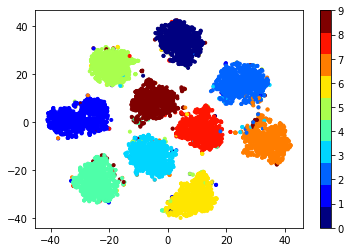

In [10]:
import matplotlib.pyplot as plt

plt.scatter(
    tsne_embeddings[:, 0], 
    tsne_embeddings[:, 1],
    c=y_test, 
    cmap=plt.cm.get_cmap("jet", 10),  # カラーマップの指定（jet)
    marker='.' # markerの指定 (点)
)
plt.colorbar()
plt.show()

## ArcFace

### ArcFaceのLayerを定義

参考: https://github.com/4uiiurz1/keras-arcface

In [11]:
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import tensorflow as tf

class ArcFace(layers.Layer):
    def __init__(self, n_classes=10, s=30.0,
                 m=0.50, regularizer=None, **kwargs):
        super().__init__(**kwargs)
        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.regularizer = regularizers.get(regularizer)

    def build(self, input_shape):
        super().build(input_shape[0])
        self.W = self.add_weight(
            name='W',
            shape=(input_shape[0][-1], self.n_classes),
            initializer='glorot_uniform',
            trainable=True,
            regularizer=self.regularizer)

    def call(self, inputs):
        x, y = inputs
        x = tf.nn.l2_normalize(x, axis=1)  # ①
        W = tf.nn.l2_normalize(self.W, axis=0)
        logits = x @ W  # ②
        clipped_logits = K.clip(
            logits,
            -1.0 + K.epsilon(),
            1.0 - K.epsilon())
        theta = tf.acos(clipped_logits)  # ③
        target_logits = tf.cos(theta + self.m)
        logits = logits * (1 - y) + target_logits * y # ④
        logits *= self.s # ⑥
        out = tf.nn.softmax(logits)
        return out

    def compute_output_shape(self, input_shape):
        return (None, self.n_classes)

### ArcFaceを接続

In [12]:
import numpy as np

num_classes = 10

input_layer = layers.Input(shape=(28, 28, 1))

x = layers.Conv2D(filters=64, kernel_size=2,
                  padding='same', activation='relu')(input_layer)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=32, kernel_size=2,
                  padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation=None)(x)
y = layers.Input(shape=(10,))
output = ArcFace(n_classes=num_classes,
                 regularizer=regularizers.l2(1e-4))([x, y])

model = tf.keras.Model([input_layer, y], output)

### ArcFaceの学習

In [13]:
from tensorflow.keras.utils import to_categorical

y_cate_train = to_categorical(y_train, 10)
y_cate_test = to_categorical(y_test, 10)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit([x_train, y_cate_train], y_cate_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 9s 4ms/step - loss: 1.4527 - accuracy: 0.8367
Epoch 2/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.7022 - accuracy: 0.9064
Epoch 3/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.5043 - accuracy: 0.9266
Epoch 4/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3629 - accuracy: 0.9410
Epoch 5/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2674 - accuracy: 0.9510


### モデルを利用する

In [14]:
import numpy as np 
from tensorflow.keras import models

embedding_model = models.Model(
    inputs=model.input[0],
    outputs=model.layers[-3].output)
embeddings = embedding_model.predict(x_test, verbose=1)
embeddings /= np.linalg.norm(embeddings, axis=1, keepdims=True)

313/313 [==============================] - 0s 1ms/step
